## MVP for GrowBikeNet implementation

In [1]:
# import libraries
import os

import pandas as pd
import geopandas as gpd
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import MultiLineString

# import functions
from src.functions import intersects_properly, create_potential_triangulation, get_correct_edgetuples, get_seed_points, snap_seed_points, filter_seed_points

# import visualization
from src.visualizations import make_video, create_plots

### User Input:

In [2]:
city_name = 'Oelde'
seed_point_spacing = 3000 # distance between seed points, in meters
orig_crs = '4326'
proj_crs = '3857'
seed_point_delta = 500 # maximal distance between seed point and actual point in OSM data, in meters

### Data from OSM

In [3]:
# fetch street network data from osmnx
g = ox.graph_from_place(
    city_name, network_type='all'
)
g_undir = g.to_undirected().copy() # convert to undirected (dropping OSMnx keys!)

# # plausibility check
# ox.plot_graph(g, figsize=(10, 10))

### Street network data

In [4]:
# export osmnx data to gdfs
nodes, edges = ox.graph_to_gdfs(
    g_undir,
    nodes=True,
    edges=True,
    node_geometry=True,
    fill_edge_geometry=True
)

# save "original" graph data (in orig_crs)
nodes.to_file("nodes.gpkg", driver='GPKG')
edges.to_file("edges.gpkg", driver='GPKG')

# replace after dropping edges with key = 1
edges = edges.loc[:,:,0].copy()
# this also means we are dropping the "key" level from edge index (u,v,key becomes: u,v)

# project geometries of nodes and edges
edges = edges.to_crs(proj_crs)
nodes = nodes.to_crs(proj_crs)

# add osm ID as column to node gdf
nodes["osmid"] = nodes.index

### Seed points

In [5]:
seed_points = get_seed_points(edges, proj_crs, seed_point_spacing)
# plausibility check
# seed_points.plot() 

### Snap Seed points to OSM nodes

In [25]:
seed_points_snapped = snap_seed_points(seed_points, nodes)
seed_points_snapped = filter_seed_points(seed_points_snapped, seed_point_delta)

NameError: name 'filter_seed_points' is not defined

<Axes: >

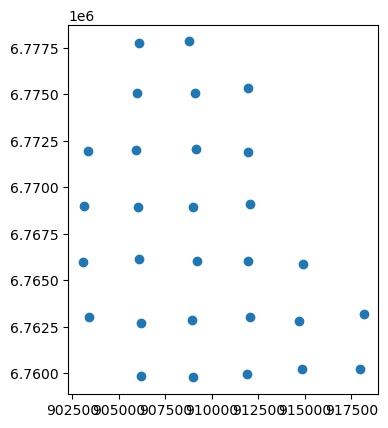

In [7]:
# plausibility check
seed_points_snapped.plot()

### Greedy triangulation

In [8]:
df = create_potential_triangulation(seed_points_snapped)

,pair,potential_edge,dist
0,"(371255801, 650811394)",LINESTRING (903334.3240901956 6771933.41901933...,2580.501930
1,"(773660219, 303023974)",LINESTRING (914825.1672078406 6760195.98998956...,2628.827369
2,"(506709431, 303023974)",LINESTRING (912037.9164015113 6763035.56718033...,2648.926502
3,"(5963881706, 406618283)",LINESTRING (906095.5817954246 6777777.89048421...,2699.456804
4,"(6882744812, 5963881706)",LINESTRING (905949.419304013 6775066.464783357...,2715.362371
5,"(2702088225, 9501048789)",LINESTRING (906197.795351871 6762684.203540062...,2760.806221
6,"(414997282, 281840800)",LINESTRING (909174.1000494146 6766050.19463454...,2764.131056
7,"(9575999249, 378252745)",LINESTRING (906073.9746822616 6766159.32621183...,2766.514526
8,"(8158663697, 859334009)",LINESTRING (912029.2334812295 6769097.82391690...,2768.834430
9,"(446041233, 406618283)",LINESTRING (909095.9871627248 6775050.74661301...,2799.508059


In [9]:
# step 2: iterate through all potential edges;
# if they dont intersect with existing edges add to multilinestring

current_edges = MultiLineString()
edge_list = []

for i, row in df.iterrows():
    new_edge = row.potential_edge
    pair = row.pair
    if not intersects_properly(current_edges, new_edge):
        current_edges = MultiLineString([linestring for linestring in current_edges.geoms] + [new_edge])
        edge_list.append(pair)

In [10]:
# step 3: make graph object from edge list
A = nx.Graph()
A.add_nodes_from(seed_points_snapped.index)
A.add_edges_from(edge_list)

In [11]:
# step 4: add betweenness attributes to edges
bc_values = nx.edge_betweenness_centrality(A, normalized=True)
nx.set_edge_attributes(A, bc_values, name='betweenness_centrality')

In [12]:
# # commenting this out for now since we don't have ranking by closeness implemented yet
# # step 5: add closeness attributes to nodes
# closeness = nx.closeness_centrality(A)
# nx.set_node_attributes(A, closeness, name='closeness_centrality')

In [13]:
# step 6: export attributes to gdfs

# as above - commenting out because closeness not yet implemented
# a_nodes = pd.DataFrame.from_dict(
#     nx.get_node_attributes(
#         G=A, 
#         name="closeness_centrality"), 
#     orient="index",
#     columns = ["closeness_centrality"]
# )
# a_nodes["node"] = a_nodes.index
# a_nodes.reset_index(drop=True, inplace=True)

a_edges = pd.DataFrame.from_dict(
    nx.get_edge_attributes(
        G=A,
        name="betweenness_centrality",
    ),
    orient="index",
    columns=["betweenness_centrality"]
)
a_edges["node_tuple"] = a_edges.index
a_edges["source"] = [t[0] for t in a_edges.node_tuple]
a_edges["target"] = [t[1] for t in a_edges.node_tuple]
a_edges.drop(columns=["node_tuple"], inplace=True)

# step 7: rank by attribute/sorting metric
a_edges = a_edges.sort_values(by='betweenness_centrality', ascending = False)
a_edges.reset_index(drop=True, inplace=True)
a_edges["rank"] = a_edges.index # ranking is simply the order of appearance in the betweenness ranking
a_edges.head()

,betweenness_centrality,source,target,rank
0,0.112389,9575999249,414054457,0
1,0.087850,286933756,482842756,1
2,0.085573,6765749025,482842756,2
3,0.081643,414054457,8158663697,3
4,0.078995,9575999249,9501048789,4


In [14]:
# step 8: map each abstract edge to a merged geometry of corresponding osmnx edges (routed on g_undir)

# step 8a: get edge list that we can use to index our edges gdf
paths = []
for _, row in a_edges.iterrows():
    paths.append(
        nx.shortest_path(
            G=g_undir, # !! use undirected graph here
            source=int(row.source),
            target=int(row.target), 
            weight='length')
    )
a_edges["path_nodes"] = paths
a_edges["path_edges"] = a_edges.path_nodes.apply(lambda x: get_correct_edgetuples(edges, x))
# now the column path_edges contains a set of osmnx edges for each row (abstract edge)

# Step 8b: get "routed" geometry (LineString) for each abstract edge (row)

# get geometry by merging all geoms from edge gdf
a_edges["geometry"] = a_edges.path_edges.apply(
    lambda x: edges.loc[x].geometry.union_all()
)
# convert a_edges into a gdf
a_edges = gpd.GeoDataFrame(a_edges, crs = edges.crs, geometry="geometry")
# merge multilinestring into linestring where possible (should be possible everywhere)
a_edges["geometry"] = a_edges.line_merge()

In [15]:
# plausibility check: now a_edges contains all of our results we wanted to get,
# will be saving a_edges to file, then plotting.
a_edges.head()

,betweenness_centrality,source,target,rank,path_nodes,path_edges,geometry
0,0.112389,9575999249,414054457,0,"[9575999249, 9575999244, 414209565, 395681350,...","[(9575999244, 9575999249), (414209565, 9575999...","LINESTRING (906073.975 6766159.326, 906111.768..."
1,0.087850,286933756,482842756,1,"[286933756, 281842218, 482842724, 482842730, 1...","[(281842218, 286933756), (281842218, 482842724...","LINESTRING (918177.476 6763168.669, 918194.029..."
2,0.085573,6765749025,482842756,2,"[6765749025, 6765749026, 6765749024, 687382266...","[(6765749025, 6765749026), (6765749024, 676574...","LINESTRING (918177.476 6763168.669, 918194.029..."
3,0.081643,414054457,8158663697,3,"[414054457, 414054471, 414054468, 414054465, 4...","[(414054457, 414054471), (414054468, 414054471...","LINESTRING (909000.475 6768911.364, 909006.074..."
4,0.078995,9575999249,9501048789,4,"[9575999249, 9575999244, 414209565, 319972186,...","[(9575999244, 9575999249), (414209565, 9575999...","LINESTRING (908952.329 6762870.197, 908976.931..."


<Axes: >

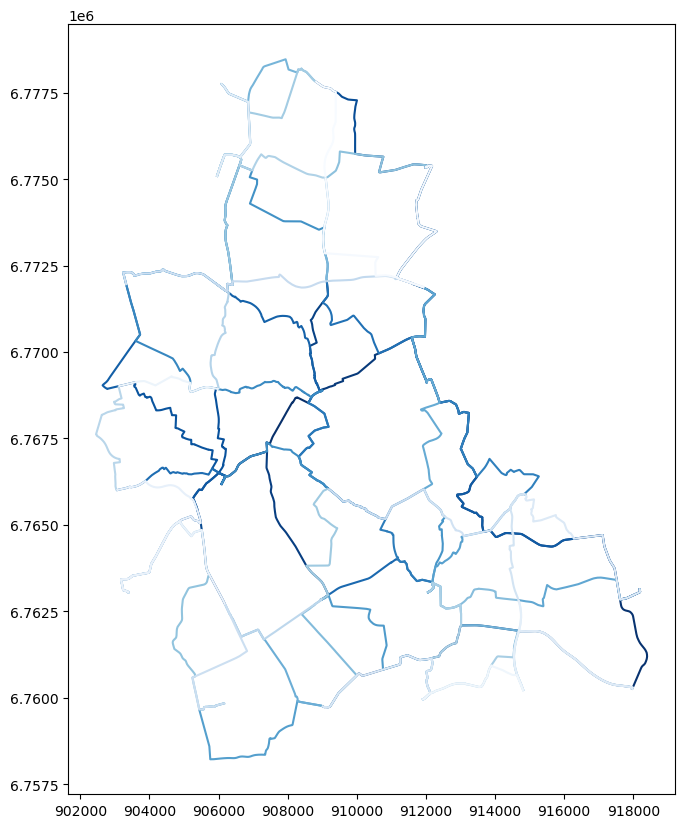

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
a_edges.plot(ax=ax, column="rank", cmap="Blues_r")
#seed_points_snapped.plot(ax=ax, color="grey")

In [17]:
# Step 9: save to file
a_edges.to_file("a_edges.gpkg", driver="GPKG")

### Visualization

In [18]:
# create directories
os.makedirs("./results/", exist_ok=True)
os.makedirs("./results/plots/", exist_ok=True)
os.makedirs("./results/plots/video/", exist_ok=True)

In [19]:
# read in file to plot
routed_edges_gdf = gpd.read_file("a_edges.gpkg")

In [20]:
# viz/plot settings (move to config file later)

# define color palette (from Michael's project: https://github.com/mszell/bikenwgrowth/blob/main/parameters/parameters.py)
streetcolor = "#999999"
edgecolor = "#0EB6D2"
seedcolor = "#ff7338"

# define linewidths

lws = {
   "street": 0.75,
   "bike": 2
}

In [21]:
create_plots(routed_edges_gdf,seed_points_snapped,streetcolor,edgecolor,seedcolor,lws)

In [22]:
make_video(
    img_folder_name="./results/plots/",
    fps = 1
)